#### To create road segmantation masks for the data

In [5]:
import os
from PIL import Image
import numpy as np

# Path to the root folder containing all the `train`, `val`, and `test` folders
root_dataset_dir = r'C:\Users\DELL\Desktop\SSY340_Project\gtFine_trainvaltest\gtFine'  # This is the root folder for gtFine which contains train, val, and test subdirectories

# Define the RGB value for the road class (from Cityscapes documentation)
road_color = [128, 64, 128]  # Road class RGB
# Define the RGB value for non-road areas (e.g., black or any other color)
non_road_color = [0, 0, 0]  # Color for non-road areas

# Function to convert a colored segmentation mask into a road-only mask with other areas colored differently
def convert_to_road_and_other(annotation_path):
    # Load the annotation (color segmentation mask)
    annotation = Image.open(annotation_path)
    annotation_array = np.array(annotation)
    
    # Determine if the image has 3 or 4 channels (RGB or RGBA)
    num_channels = annotation_array.shape[-1]
    
    # Update road and non-road colors to match the number of channels (3 for RGB, 4 for RGBA)
    if num_channels == 4:
        road_color_with_alpha = [128, 64, 128, 255]  # Add alpha channel for road color
        non_road_color_with_alpha = [128, 128, 64, 255]  # Add alpha channel for non-road areas
        road_color = road_color_with_alpha
        non_road_color = non_road_color_with_alpha
    else:
        road_color = [128, 64, 128]  # RGB road color
        non_road_color = [128, 128, 64]  # RGB non-road color
    
    # Create a mask where road pixels are retained and non-road pixels are set to a different color
    road_mask = np.all(annotation_array[:, :, :3] == road_color[:3], axis=-1)  # Compare RGB values only

    # Create an output array, initially filled with the non-road color
    output_mask = np.full_like(annotation_array, non_road_color, dtype=np.uint8)
    
    # Set the road pixels to their original color
    output_mask[road_mask] = road_color
    
    return output_mask


# Function to process all the annotations in a given folder (train, val, test)
def process_all_annotations(root_dir, output_dir):
    # Traverse through all the city folders and files in the root directory
    for city_folder in os.listdir(root_dir):
        city_folder_path = os.path.join(root_dir, city_folder)
        
        if os.path.isdir(city_folder_path):  # Only process directories (cities)
            for filename in os.listdir(city_folder_path):
                if filename.endswith('_gtFine_color.png'):  # Only process color segmentation masks
                    annotation_path = os.path.join(city_folder_path, filename)
                    
                    # Convert the mask to road-only with custom colors
                    output_mask = convert_to_road_and_other(annotation_path)
                    
                    # Create the output directory for the city if it doesn't exist
                    city_output_dir = os.path.join(output_dir, city_folder)
                    os.makedirs(city_output_dir, exist_ok=True)
                    
                    # Save the output mask as a PNG file
                    output_path = os.path.join(city_output_dir, filename.replace('_gtFine_color.png', '_road_custom_mask.png'))
                    output_image = Image.fromarray(output_mask.astype(np.uint8))
                    output_image.save(output_path)

# Process train, val, and test sets
def process_dataset(root_dataset_dir, output_base_dir):
    for split in ['train', 'val', 'test']:
        split_dir = os.path.join(root_dataset_dir, split)  # Path to train, val, or test folder
        output_dir = os.path.join(output_base_dir, split)  # Output directory for each split
        
        print(f"Processing {split} set...")
        process_all_annotations(split_dir, output_dir)
        print(f"Finished processing {split} set.")

# Example usage
output_base_dir = r'C:\Users\DELL\Desktop\SSY340_Project\gt_custom'  # Base output directory where masks will be saved
process_dataset(root_dataset_dir, output_base_dir)

print("All road masks with custom colors have been saved for train, val, and test sets.")


Processing train set...
Finished processing train set.
Processing val set...
Finished processing val set.
Processing test set...
Finished processing test set.
All road masks with custom colors have been saved for train, val, and test sets.


#### Load the dataset

In [9]:
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision.transforms as transforms
import torch
import numpy as np

road_color = [128, 64, 128]  # RGB value for road
non_road_color = [128, 128, 64]  # RGB value for non-road

class CityscapesDataset(Dataset):
    def __init__(self, img_dir, mask_dir, transform=None, mask_transform=None):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.mask_transform = mask_transform
        
        self.img_files = []
        self.mask_files = []
        
        for city in os.listdir(self.img_dir):
            city_path = os.path.join(self.img_dir, city)
            for img_file in os.listdir(city_path):
                if img_file.endswith('_leftImg8bit.png'):
                    self.img_files.append(os.path.join(city_path, img_file))
                    mask_file = img_file.replace('_leftImg8bit.png', '_road_custom_mask.png')
                    self.mask_files.append(os.path.join(self.mask_dir, city, mask_file))
    
    def __len__(self):
        return len(self.img_files)

    def preprocess_mask(self, mask):
        mask_array = np.array(mask)

        if mask_array.shape[-1] == 4:
            mask_array = mask_array[:, :, :3]

        if mask_array.ndim != 3 or mask_array.shape[-1] != 3:
            raise ValueError(f"Expected an RGB mask with 3 channels, but got shape {mask_array.shape}.")

        binary_mask = np.all(mask_array == road_color, axis=-1).astype(np.uint8)
        binary_mask = torch.from_numpy(binary_mask).unsqueeze(0).float()

        if self.mask_transform:
            binary_mask = self.mask_transform(binary_mask)

        return binary_mask

    def __getitem__(self, idx):
        img_path = self.img_files[idx]
        img = Image.open(img_path).convert("RGB")
        mask_path = self.mask_files[idx]
        mask = Image.open(mask_path)

        if self.transform:
            img = self.transform(img)
        
        mask = self.preprocess_mask(mask)
        
        return img, mask

vgg16_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

mask_transform = transforms.Compose([
    transforms.Resize((224, 224), interpolation=Image.NEAREST)
])

def load_dataset(img_dir, mask_dir, batch_size):
    dataset = CityscapesDataset(img_dir=img_dir, mask_dir=mask_dir, transform=vgg16_transform, mask_transform=mask_transform)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    return dataset, loader

# Paths for train and val sets
img_dirs = {
    'train': r'C:\Users\DELL\Desktop\SSY340_Project\leftImg8bit\train',
    'val': r'C:\Users\DELL\Desktop\SSY340_Project\leftImg8bit\val'
}

mask_dirs = {
    'train': r'C:\Users\DELL\Desktop\SSY340_Project\gt_custom\train',
    'val': r'C:\Users\DELL\Desktop\SSY340_Project\gt_custom\val'
}

batch_size = 4

# Create loaders for train, val, and test sets
train_dataset, train_loader = load_dataset(img_dirs['train'], mask_dirs['train'], batch_size)

# Load the full validation dataset
val_dataset, val_loader = load_dataset(img_dirs['val'], mask_dirs['val'], batch_size)

# Split the validation dataset into two halves
val_size = len(val_dataset)
split = val_size // 2
val_subset = Subset(val_dataset, range(split))  # First half for validation
test_subset = Subset(val_dataset, range(split, val_size))  # Second half for testing

# Create new DataLoaders for the split datasets
val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False, num_workers=0)
cityscape_test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=False, num_workers=0)

# Output dataset sizes for verification
print(f"Training dataset size: {len(train_loader.dataset)}")
print(f"Validation dataset size: {len(val_loader.dataset)}")
print(f"Testing dataset size: {len(cityscape_test_loader.dataset)}")

# Example: Iterate through a batch of training data to verify
for images, masks in train_loader:
    print(f"Image batch shape: {images.shape}")
    print(f"Mask batch shape: {masks.shape}")  # Should be [4, 1, 224, 224]
    break  # Stop after first batch for verification


Training dataset size: 2975
Validation dataset size: 250
Testing dataset size: 250
Image batch shape: torch.Size([4, 3, 224, 224])
Mask batch shape: torch.Size([4, 1, 224, 224])


#### Create the model, set all the loss functions, optimiser etc.

In [111]:
import torch
from torch import nn
import matplotlib.pyplot as plt
from torchvision import models

# Your VGG16BinarySegmentation model definition from earlier
class VGG16BinarySegmentation(nn.Module):
    def __init__(self):
        super(VGG16BinarySegmentation, self).__init__()
        vgg16 = models.vgg16(pretrained=True)
        self.encoder = vgg16.features
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 1, kernel_size=1),
            # Do NOT add a Sigmoid() layer, as BCEWithLogitsLoss already applies it.
            nn.Upsample(size=(224, 224), mode='bilinear', align_corners=True)  # Ensure output size is 224x224
        )
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Instantiate the model, criterion, and optimizer
model = VGG16BinarySegmentation()
criterion = nn.BCEWithLogitsLoss()  # Use BCEWithLogitsLoss
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
print(model)


C:\Users\DELL\anaconda3\envs\dml\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\DELL\anaconda3\envs\dml\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG16BinarySegmentation(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, pa

#### Trying to reduce overfit

In [2]:
import torch
from torch import nn
from torchvision import models

class VGG16BinarySegmentation(nn.Module):
    def __init__(self):
        super(VGG16BinarySegmentation, self).__init__()
        vgg16 = models.vgg16(pretrained=True)
        self.encoder = vgg16.features
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2),
            nn.BatchNorm2d(256),  # Add batch normalization
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),  # Add dropout
            
            nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2),
            nn.BatchNorm2d(128),  # Add batch normalization
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),  # Add dropout
            
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
            nn.BatchNorm2d(64),  # Add batch normalization
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),  # Add dropout
            
            nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2),
            nn.BatchNorm2d(32),  # Add batch normalization
            nn.ReLU(inplace=True),
            
            nn.Conv2d(32, 1, kernel_size=1),
            # Do NOT add a Sigmoid() layer, as BCEWithLogitsLoss already applies it.
            nn.Upsample(size=(224, 224), mode='bilinear', align_corners=True)  # Ensure output size is 224x224
        )
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Instantiate the model, criterion, and optimizer
model = VGG16BinarySegmentation()
criterion = nn.BCEWithLogitsLoss()  # Use BCEWithLogitsLoss

# Add weight decay for L2 regularization
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
print(model)


C:\Users\DELL\anaconda3\envs\dml\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\DELL\anaconda3\envs\dml\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG16BinarySegmentation(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, pa

#### Train model

In [113]:
# Training function
def train_one_epoch(model, train_loader, criterion, optimizer):
    model.train()  # Set model to training mode
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        
        # Calculate accuracy (use threshold 0.5 for binary classification)
        preds = (outputs > 0.5).float()
        correct += (preds == masks).sum().item()
        total += masks.numel()  # Total number of pixels
        
        running_loss += loss.item()
    
    avg_loss = running_loss / len(train_loader)
    accuracy = correct / total
    return avg_loss, accuracy

# Validation function
def validate_one_epoch(model, val_loader, criterion):
    model.eval()  # Set model to evaluation mode
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, masks)
            
            preds = (outputs > 0.5).float()
            correct += (preds == masks).sum().item()
            total += masks.numel()
            
            running_loss += loss.item()
    
    avg_loss = running_loss / len(val_loader)
    accuracy = correct / total
    return avg_loss, accuracy

In [114]:
import torch.optim as optim
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, jaccard_score, confusion_matrix
import numpy as np
import seaborn as sns

def train_and_evaluate(model, train_loader, val_loader, criterion, optimizer, num_epochs=5):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    f1_scores = []
    jaccard_indices = []
    confusion_matrices = []

    for epoch in range(num_epochs):
        epoch_loss = 0
        total_correct_train = 0
        total_pixels_train = 0

        model.train()  # Set to training mode
        print(f"Start epoch {epoch+1}/{num_epochs}")

        for index, (image, mask) in enumerate(train_loader):
            image, mask = image.to(device), mask.to(device)

            optimizer.zero_grad()
            output = model(image)
            loss = criterion(output, mask)

            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            preds = torch.sigmoid(output) > 0.5
            total_correct_train += (preds == mask.byte()).sum().item()
            total_pixels_train += mask.numel()

        # Store training loss and accuracy
        train_losses.append(epoch_loss / len(train_loader))
        train_accuracy = total_correct_train / total_pixels_train
        train_accuracies.append(train_accuracy)

        print(f"Epoch [{epoch + 1}/{num_epochs}], Training Loss: {epoch_loss / len(train_loader)}, Training Accuracy: {train_accuracy:.4f}")

        # Evaluation phase
        model.eval()  # Set to evaluation mode
        eval_loss = 0
        total_correct_eval = 0
        total_pixels_eval = 0
        all_preds = []
        all_masks = []

        with torch.no_grad():
            for eval_image, eval_mask in val_loader:
                eval_image, eval_mask = eval_image.to(device), eval_mask.to(device)
                
                eval_output = model(eval_image)
                eval_loss += criterion(eval_output, eval_mask).item()

                preds = torch.sigmoid(eval_output) > 0.5
                total_correct_eval += (preds == eval_mask.byte()).sum().item()
                total_pixels_eval += eval_mask.numel()

                # Convert predictions and masks to CPU for metric calculations
                all_preds.append(preds.cpu().numpy().flatten())
                all_masks.append(eval_mask.cpu().numpy().flatten())

        # Calculate F1-Score and Jaccard Index (IoU) using sklearn
        all_preds = np.concatenate(all_preds)
        all_masks = np.concatenate(all_masks)

        f1 = f1_score(all_masks, all_preds, average='binary')
        jaccard = jaccard_score(all_masks, all_preds, average='binary')
        f1_scores.append(f1)
        jaccard_indices.append(jaccard)

        print(f"F1-Score: {f1:.4f}, Jaccard Index (IoU): {jaccard:.4f}")

        # Confusion Matrix
        conf_matrix = confusion_matrix(all_masks, all_preds)
        confusion_matrices.append(conf_matrix)

        print(f"Confusion Matrix at Epoch {epoch + 1}:")
        print(conf_matrix)

        # Store evaluation loss and accuracy
        val_losses.append(eval_loss / len(val_loader))
        val_accuracy = total_correct_eval / total_pixels_eval
        val_accuracies.append(val_accuracy)

        print(f"Epoch [{epoch + 1}/{num_epochs}], Validation Loss: {eval_loss / len(val_loader)}, Validation Accuracy: {val_accuracy:.4f}")

    # Plot the metrics at the end of all epochs
    plot_metrics(
        epochs=range(1, num_epochs + 1),
        train_losses=train_losses,
        eval_losses=val_losses,
        train_accuracies=train_accuracies,
        eval_accuracies=val_accuracies,
        f1_scores=f1_scores,
        jaccard_indices=jaccard_indices,
        confusion_matrices=confusion_matrices
    )


# Plot metrics function
def plot_metrics(epochs, train_losses, eval_losses, train_accuracies, eval_accuracies, f1_scores, jaccard_indices, confusion_matrices):
    plt.figure(figsize=(20, 6))

    # Plotting Losses
    plt.subplot(1, 3, 1)
    plt.plot(epochs, train_losses, label='Training Loss')
    plt.plot(epochs, eval_losses, label='Evaluation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Evaluation Loss')
    plt.legend()

    # Plotting Accuracy
    plt.subplot(1, 3, 2)
    plt.plot(epochs, train_accuracies, label='Training Accuracy')
    plt.plot(epochs, eval_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    # Plot F1-Score and Jaccard Index
    plt.figure(figsize=(6, 6))
    plt.plot(epochs, f1_scores, label='F1-Score')
    plt.plot(epochs, jaccard_indices, label='Jaccard Index (IoU)')
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.title('F1-Score and Jaccard Index')
    plt.legend()
    plt.show()

    plt.figure(figsize=(6, 5))
    sns.heatmap(confusion_matrices[-1], annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix at final Epoch')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

print("Running...")
train_and_evaluate(model, train_loader, val_loader, criterion, optimizer, num_epochs=8)


Running...
Start epoch 1/8
Epoch [1/8], Training Loss: 0.17364591187495979, Training Accuracy: 0.9357


ValueError: Classification metrics can't handle a mix of continuous and binary targets

#### Save model

In [4]:
def save_checkpoint(model, optimizer, epoch, file_path):
    """Saves the model and optimizer state to a checkpoint file."""
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }
    torch.save(checkpoint, file_path)
    print(f"Checkpoint saved to {file_path}")

def load_checkpoint(model, optimizer, file_path):
    """Loads the model and optimizer state from a checkpoint file."""
    checkpoint = torch.load(file_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    print(f"Checkpoint loaded from {file_path}, starting from epoch {epoch}")
    return epoch

In [130]:
# Assume training has completed, and you want to save everything
final_epoch = 5  # The final epoch after training
checkpoint_path = 'vgg16_segmentation_reduceoverfit_16_comma10kdata_checkpoint.pth'  # Define the checkpoint file path

# Save the final checkpoint (model, optimizer, and epoch)
save_checkpoint(model, optimizer, final_epoch, checkpoint_path)
print("Checkpoint saved.")


Checkpoint saved to vgg16_segmentation_reduceoverfit_16_comma10kdata_checkpoint.pth
Checkpoint saved.


#### LOAD TRAINED MODEL

In [5]:
# Load the checkpoint
checkpoint_path = 'vgg16_segmentation_reduceoverfit_16_comma10kdata_checkpoint.pth'  # Specify the path to your checkpoint file

# Initialize your model and optimizer first
model = VGG16BinarySegmentation()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Load the checkpoint
load_checkpoint(model, optimizer, checkpoint_path)
model.to(device)

C:\Users\DELL\AppData\Local\Temp\ipykernel_15596\860490446.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(file_path)


Checkpoint loaded from vgg16_segmentation_reduceoverfit_16_comma10kdata_checkpoint.pth, starting from epoch 5


VGG16BinarySegmentation(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, pa

#### Test on cityscapes data (250 images)

In [7]:
import torch.optim as optim
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, jaccard_score, confusion_matrix
import numpy as np
import seaborn as sns

def test_model(model, test_loader, criterion):
    model.eval()  # Set model to evaluation mode
    running_loss = 0.0
    total_correct_test = 0
    total_pixels_test = 0
    all_preds = []
    all_masks = []

    with torch.no_grad():
        for test_image, test_mask in test_loader:
            test_image, test_mask = test_image.to(device), test_mask.to(device)

            test_output = model(test_image)
            loss = criterion(test_output, test_mask)

            preds = (torch.sigmoid(test_output) > 0.5).float()  # Convert predictions to binary
            total_correct_test += (preds == test_mask.byte()).sum().item()
            total_pixels_test += test_mask.numel()

            # Store predictions and masks for metrics
            all_preds.append(preds.cpu().numpy().flatten())
            all_masks.append(test_mask.cpu().numpy().flatten())

            running_loss += loss.item()

    avg_loss = running_loss / len(test_loader)
    accuracy = total_correct_test / total_pixels_test

    # Calculate F1-Score and Jaccard Index (IoU) using sklearn
    all_preds = np.concatenate(all_preds)
    all_masks = np.concatenate(all_masks)

    # Ensure all_preds and all_masks are binary
    all_preds = (all_preds > 0.5).astype(np.uint8)  # Ensure predictions are binary
    all_masks = (all_masks > 0.5).astype(np.uint8)  # Ensure masks are binary

    f1 = f1_score(all_masks, all_preds, average='binary')
    jaccard = jaccard_score(all_masks, all_preds, average='binary')

    # Confusion Matrix
    conf_matrix = confusion_matrix(all_masks, all_preds)

    print(f"Test Loss: {avg_loss:.4f}, Test Accuracy: {accuracy:.4f}")
    print(f"F1-Score: {f1:.4f}, Jaccard Index (IoU): {jaccard:.4f}")
    print("Confusion Matrix:")
    print(conf_matrix)

    # Optionally visualize the confusion matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix on Test Data')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    return avg_loss, accuracy, f1, jaccard, conf_matrix


Testing the model...
Test Loss: 0.1342, Test Accuracy: 0.9525
F1-Score: 0.9262, Jaccard Index (IoU): 0.8626
Confusion Matrix:
[[8203481  363227]
 [ 233044 3744248]]


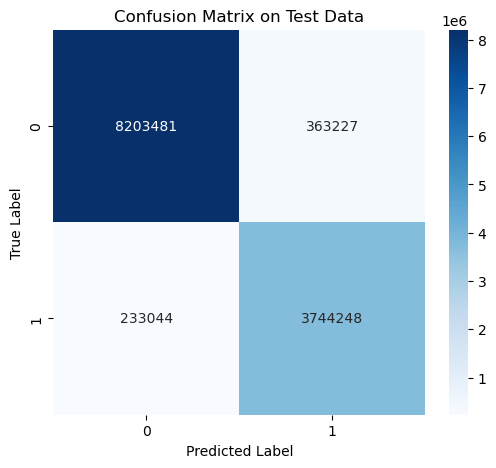

In [9]:
# Assuming you have already defined model, criterion, optimizer, and loaded the test_loader
print("Testing the model...")
test_loss, test_accuracy, test_f1, test_jaccard, test_confusion_matrix = test_model(model, cityscape_test_loader, criterion)


#### Visualise forward pass

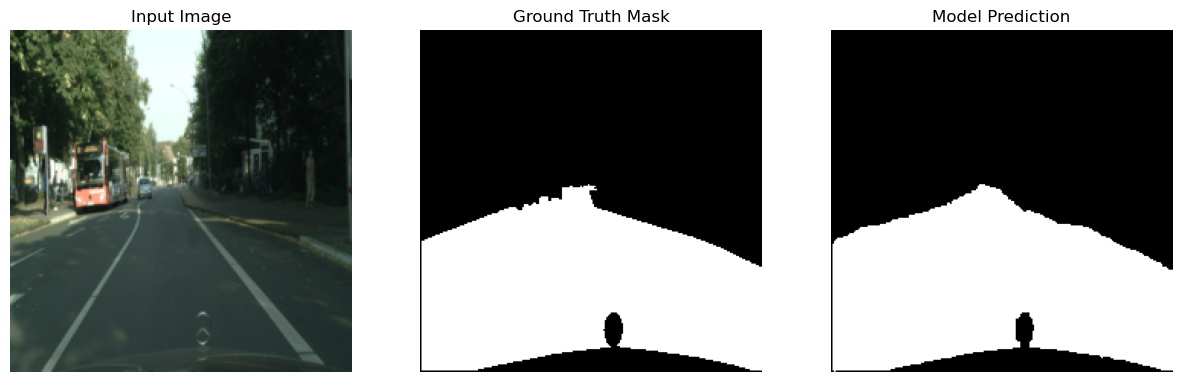

In [94]:
import random
import matplotlib.pyplot as plt
import torch

# Ensure your model is loaded (assuming model is your VGG16BinarySegmentation instance)
model.eval()  # Set the model to evaluation mode

# Denormalization function
def denormalize(image):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1)  # Reshape for broadcasting
    std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1)  # Reshape for broadcasting
    denormalized_image = image * std + mean
    return denormalized_image.clamp(0, 1)  # Ensure values are within [0, 1]

# Function to visualize images and masks
def visualize_output(image, mask, prediction):
    plt.figure(figsize=(15, 5))

    # Input Image
    plt.subplot(1, 3, 1)
    denormalized_image = denormalize(image.unsqueeze(0))  # Denormalize the image (add batch dimension)
    plt.imshow(denormalized_image.squeeze(0).permute(1, 2, 0).numpy())  # Squeeze and permute for visualization
    plt.title("Input Image")
    plt.axis('off')

    # Ground Truth Mask
    plt.subplot(1, 3, 2)
    plt.imshow(mask.squeeze(0).numpy(), cmap='gray')  # Squeeze to remove channel dimension
    plt.title("Ground Truth Mask")
    plt.axis('off')

    # Model Prediction
    plt.subplot(1, 3, 3)
    plt.imshow(prediction.squeeze(0).detach().numpy(), cmap='gray', vmin=0, vmax=1)  # Set vmin and vmax for correct scaling
    plt.title("Model Prediction")
    plt.axis('off')

    plt.show()

# Get a random test image
random_index = random.randint(0, len(test_loader.dataset) - 1)
test_image, test_mask = test_loader.dataset[random_index]

# Prepare the test image for the model
test_image = test_image.unsqueeze(0).to(device)  # Add batch dimension and send to device

# Forward pass through the model
with torch.no_grad():
    output = model(test_image)  # Get the output from the model

# Apply a sigmoid activation to the output and threshold it to create a binary mask
predicted_mask = (torch.sigmoid(output) > 0.5).float()  # Binary mask

# Visualize the input image, ground truth mask, and predicted mask
visualize_output(test_image.squeeze(0).cpu(), test_mask.squeeze(0).cpu(), predicted_mask.squeeze(0).cpu())


#### Test on KITTI data (289 images)

#### Load KITTI

In [8]:
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import numpy as np
import torch

class KITTIDataset(Dataset):
    def __init__(self, img_dir, mask_dir, transform=None):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.transform = transform
        
        # Get a list of all images and masks
        self.img_files = sorted([f for f in os.listdir(img_dir) if f.endswith('.png')])
        self.mask_files = sorted([f for f in os.listdir(mask_dir) if f.endswith('.png')])
        
        # Ensure both lists are of the same length
        if len(self.img_files) != len(self.mask_files):
            raise ValueError(f"Number of images {len(self.img_files)} does not match number of masks {len(self.mask_files)}")
        
        # Create pairs based on their order in the directories
        self.pairs = [(os.path.join(img_dir, img), os.path.join(mask_dir, mask)) 
                      for img, mask in zip(self.img_files, self.mask_files)]

    def __len__(self):
        return len(self.pairs)

    def preprocess_mask(self, mask):
        """
        Convert a colored mask to a binary mask:
        - 1 for road (RGB: [255, 0, 255])
        - 0 for non-road (RGB: [255, 0, 0])
        """
        # Convert the mask to a NumPy array
        mask_array = np.array(mask)

        # Create a binary mask: 1 for road, 0 for non-road
        binary_mask = np.zeros(mask_array.shape[:2], dtype=np.uint8)  # Initialize binary mask
        binary_mask[(mask_array[:, :, 0] == 255) & (mask_array[:, :, 1] == 0) & (mask_array[:, :, 2] == 255)] = 1  # Road
        binary_mask[(mask_array[:, :, 0] == 255) & (mask_array[:, :, 1] == 0) & (mask_array[:, :, 2] == 0)] = 0  # Non-road

        # Convert to a torch tensor and add a channel dimension (1xHxW)
        binary_mask = torch.from_numpy(binary_mask).unsqueeze(0).float()

        return binary_mask

    def __getitem__(self, idx):
        img_path, mask_path = self.pairs[idx]
        img = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path)

        # Apply transformations to the image
        if self.transform:
            img = self.transform(img)
        
        # Resize the mask to match the image size
        mask = mask.resize((224, 224), Image.NEAREST)  # Ensure mask is resized correctly

        # Preprocess the mask (convert to binary)
        mask = self.preprocess_mask(mask)
        
        return img, mask


# Define your transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to match model input
    transforms.ToTensor(),
])

# Create the dataset
kitti_data_dir = r'C:\Users\DELL\Desktop\SSY340_Project\kitti_data_road\data_road\training\image_2'  # Path to the image_2 folder
kitti_gt_dir = r'C:\Users\DELL\Desktop\SSY340_Project\kitti_data_road\data_road\training\gt_image_2'  # Path to the ground truth folder
kitti_dataset = KITTIDataset(img_dir=kitti_data_dir, mask_dir=kitti_gt_dir, transform=transform)

# Create DataLoader
kitti_loader = DataLoader(kitti_dataset, batch_size=4, shuffle=False)  # Adjust batch size as needed

# Output number of samples in the dataset for verification
print(f"Number of samples in the dataset: {len(kitti_dataset)}")


Number of samples in the dataset: 289


Testing the model on KITTI dataset...
Test Loss: 0.2435, Test Accuracy: 0.9205
F1-Score: 0.7640, Jaccard Index (IoU): 0.6182
Confusion Matrix:
[[11483294   451344]
 [  700816  1865410]]


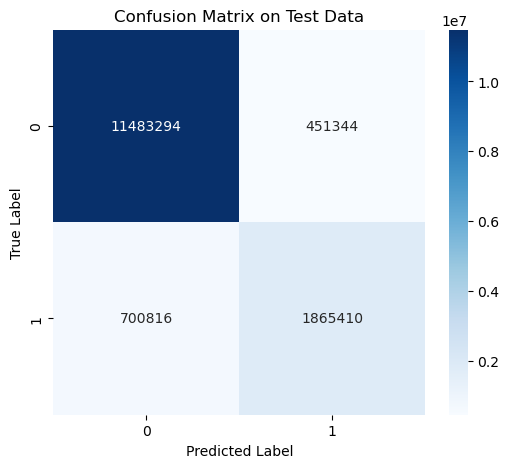

In [12]:
print("Testing the model on KITTI dataset...")
test_loss, test_accuracy, test_f1, test_jaccard, test_conf_matrix = test_model(model, kitti_loader, criterion)

#### Test on comma10k data

#### Load data

In [14]:
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch

class Comma10kDataset(Dataset):
    def __init__(self, img_dir, mask_dir, transform=None, max_samples=250):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.transform = transform
        
        # Get a list of all images and masks
        self.img_files = []
        self.mask_files = []
        
        for img_file in os.listdir(img_dir):
            if img_file.endswith('.png'):  # Assuming your images are in PNG format
                self.img_files.append(os.path.join(img_dir, img_file))
                mask_file = img_file.replace('.png', '_binary.png')  # Assuming binary masks have a similar naming
                self.mask_files.append(os.path.join(mask_dir, mask_file))
        
        # Limit to max_samples
        self.img_files = self.img_files[:max_samples]
        self.mask_files = self.mask_files[:max_samples]

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        img_path = self.img_files[idx]
        mask_path = self.mask_files[idx]
        
        img = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")  # Load mask as grayscale
        
        if self.transform:
            img = self.transform(img)
            mask = self.transform(mask)
        
        return img, mask

# Define transformations for the images and masks
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images for the model
    transforms.ToTensor(),
])

# Create dataset instance with a limit of 250 samples
comma10k_dataset = Comma10kDataset(img_dir=r'C:\Users\DELL\Desktop\SSY340_Project\comma10k_imgs', mask_dir=r'C:\Users\DELL\Desktop\SSY340_Project\comma10k_custom', transform=transform, max_samples=250)

# Create DataLoader for evaluation
comma10k_dataloader = DataLoader(comma10k_dataset, batch_size=4, shuffle=False)  # Adjust batch size as needed

# Output number of samples in the dataset for verification
print(f"Number of samples in the dataset: {len(comma10k_dataset)}")

# Example: Iterate through a batch of data to verify
for images, masks in comma10k_dataloader:
    print(f"Image batch shape: {images.shape}")
    print(f"Mask batch shape: {masks.shape}")  # Should be [4, 1, 224, 224]
    break  # Stop after first batch for verification


Number of samples in the dataset: 250
Image batch shape: torch.Size([4, 3, 224, 224])
Mask batch shape: torch.Size([4, 1, 224, 224])


Testing the model on comma10k dataset...
Test Loss: 0.5516, Test Accuracy: 0.7952
F1-Score: 0.5084, Jaccard Index (IoU): 0.3409
Confusion Matrix:
[[8513249 1465230]
 [1191553 1373968]]


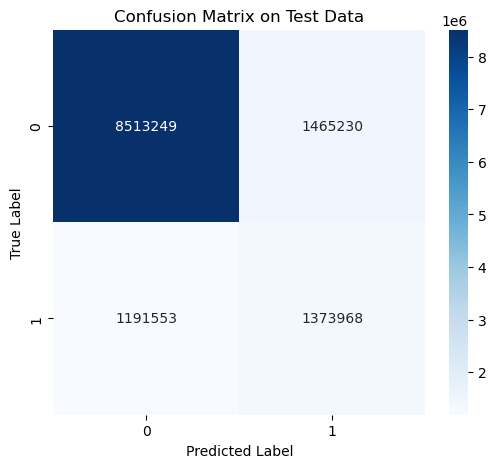

In [16]:
print("Testing the model on comma10k dataset...")
test_loss, test_accuracy, test_f1, test_jaccard, test_conf_matrix = test_model(model, comma10k_dataloader, criterion)

#### Train on comma10k data (because got night day images)

In [2]:
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch

class Comma10kDataset(Dataset):
    def __init__(self, img_dir, mask_dir, transform=None):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.transform = transform
        
        # Get a list of all images and masks
        self.img_files = []
        self.mask_files = []
        
        for img_file in os.listdir(img_dir):
            if img_file.endswith('.png'):  # Assuming your images are in PNG format
                self.img_files.append(os.path.join(img_dir, img_file))
                mask_file = img_file.replace('.png', '_binary.png')  # Assuming binary masks have a similar naming
                self.mask_files.append(os.path.join(mask_dir, mask_file))

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        img_path = self.img_files[idx]
        mask_path = self.mask_files[idx]
        
        img = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")  # Load mask as grayscale
        
        if self.transform:
            img = self.transform(img)
            mask = self.transform(mask)
        
        return img, mask

# Define transformations for the images and masks
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images for the model
    transforms.ToTensor(),
])

# Create dataset instance
dataset = Comma10kDataset(img_dir=r'C:\Users\DELL\Desktop\SSY340_Project\comma10k_imgs', mask_dir=r'C:\Users\DELL\Desktop\SSY340_Project\comma10k_custom', transform=transform)


In [3]:
sample_img, sample_mask = dataset[0]  # Get the first item
print(sample_img.size())
print(sample_mask.size())

torch.Size([3, 224, 224])
torch.Size([1, 224, 224])


In [4]:
from sklearn.model_selection import train_test_split

# Ensure you have a dataset with 5000 images
if len(dataset) > 5000:
    dataset = torch.utils.data.Subset(dataset, range(5000))  # Limit to the first 5000 images

# Define total number of images and split ratios
total_images = 5000
test_size = 1525
remaining_images = total_images - test_size
train_size = int(remaining_images * 0.8)  # 80% for training
val_size = remaining_images - train_size  # Remaining for validation

# Get the indices for train and test splits
train_indices, test_indices = train_test_split(range(len(dataset)), test_size=test_size, random_state=42)

# From the training indices, further split for validation
train_indices, val_indices = train_test_split(train_indices, test_size=val_size / (train_size + val_size), random_state=42)

# Create data subsets
train_subset = torch.utils.data.Subset(dataset, train_indices)
val_subset = torch.utils.data.Subset(dataset, val_indices)
test_subset = torch.utils.data.Subset(dataset, test_indices)

# Create DataLoaders
batch_size = 4  # Adjust as needed
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)
comma10k_test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=False)

# Output dataset sizes for verification
print(f"Training dataset size: {len(train_loader.dataset)}")
print(f"Validation dataset size: {len(val_loader.dataset)}")
print(f"Testing dataset size: {len(comma10k_test_loader.dataset)}")


Training dataset size: 2780
Validation dataset size: 695
Testing dataset size: 1525


#### Reset model

In [27]:
import torch
from torch import nn
from torchvision import models

class VGG16BinarySegmentation(nn.Module):
    def __init__(self):
        super(VGG16BinarySegmentation, self).__init__()
        vgg16 = models.vgg16(pretrained=True)
        self.encoder = vgg16.features
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2),
            nn.BatchNorm2d(256),  # Add batch normalization
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),  # Add dropout
            
            nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2),
            nn.BatchNorm2d(128),  # Add batch normalization
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),  # Add dropout
            
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
            nn.BatchNorm2d(64),  # Add batch normalization
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),  # Add dropout
            
            nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2),
            nn.BatchNorm2d(32),  # Add batch normalization
            nn.ReLU(inplace=True),
            
            nn.Conv2d(32, 1, kernel_size=1),
            # Do NOT add a Sigmoid() layer, as BCEWithLogitsLoss already applies it.
            nn.Upsample(size=(224, 224), mode='bilinear', align_corners=True)  # Ensure output size is 224x224
        )
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Instantiate the model, criterion, and optimizer
model = VGG16BinarySegmentation()
criterion = nn.BCEWithLogitsLoss()  # Use BCEWithLogitsLoss

# Add weight decay for L2 regularization
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
print(model)


C:\Users\DELL\anaconda3\envs\dml\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\DELL\anaconda3\envs\dml\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG16BinarySegmentation(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, pa

#### Experimenting

In [13]:
import torch
from torch import nn
from torchvision import models
import torchvision.transforms as transforms

class VGG16BinarySegmentation(nn.Module):
    def __init__(self, output_size=(224, 224), dropout_rate=0.6):
        super(VGG16BinarySegmentation, self).__init__()
        
        vgg16 = models.vgg16(pretrained=True)
        self.encoder = vgg16.features
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),
            
            nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),
            
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),
            
            nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(32, 1, kernel_size=1),
        )
        
        # Adaptive upsampling to desired output size
        self.output_size = output_size

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        
        # Adaptive output resizing to handle different resolutions
        x = nn.functional.interpolate(x, size=self.output_size, mode='bilinear', align_corners=True)
        return x

# Data augmentation for robustness across datasets
augmentation_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Model, criterion, and optimizer setup
model = VGG16BinarySegmentation(output_size=(224, 224), dropout_rate=0.6)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
print(model)


C:\Users\DELL\anaconda3\envs\dml\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\DELL\anaconda3\envs\dml\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG16BinarySegmentation(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, pa

Running...
Start epoch 1/6
Epoch [1/6], Training Loss: 0.3193, Training Accuracy: 0.9191
F1-Score: 0.9355, Jaccard Index (IoU): 0.8788
Confusion Matrix at Epoch 1:
[[7849847  407747]
 [ 161097 4125309]]
Epoch [1/6], Validation Loss: 0.1969, Validation Accuracy: 0.9547
Start epoch 2/6
Epoch [2/6], Training Loss: 0.1623, Training Accuracy: 0.9545
F1-Score: 0.9496, Jaccard Index (IoU): 0.9040
Confusion Matrix at Epoch 2:
[[7986670  270924]
 [ 166578 4119828]]
Epoch [2/6], Validation Loss: 0.1194, Validation Accuracy: 0.9651
Start epoch 3/6
Epoch [3/6], Training Loss: 0.1261, Training Accuracy: 0.9602
F1-Score: 0.9410, Jaccard Index (IoU): 0.8886
Confusion Matrix at Epoch 3:
[[7832667  424927]
 [ 100080 4186326]]
Epoch [3/6], Validation Loss: 0.1216, Validation Accuracy: 0.9581
Start epoch 4/6
Epoch [4/6], Training Loss: 0.1087, Training Accuracy: 0.9643
F1-Score: 0.9560, Jaccard Index (IoU): 0.9157
Confusion Matrix at Epoch 4:
[[8004563  253031]
 [ 129578 4156828]]
Epoch [4/6], Validation

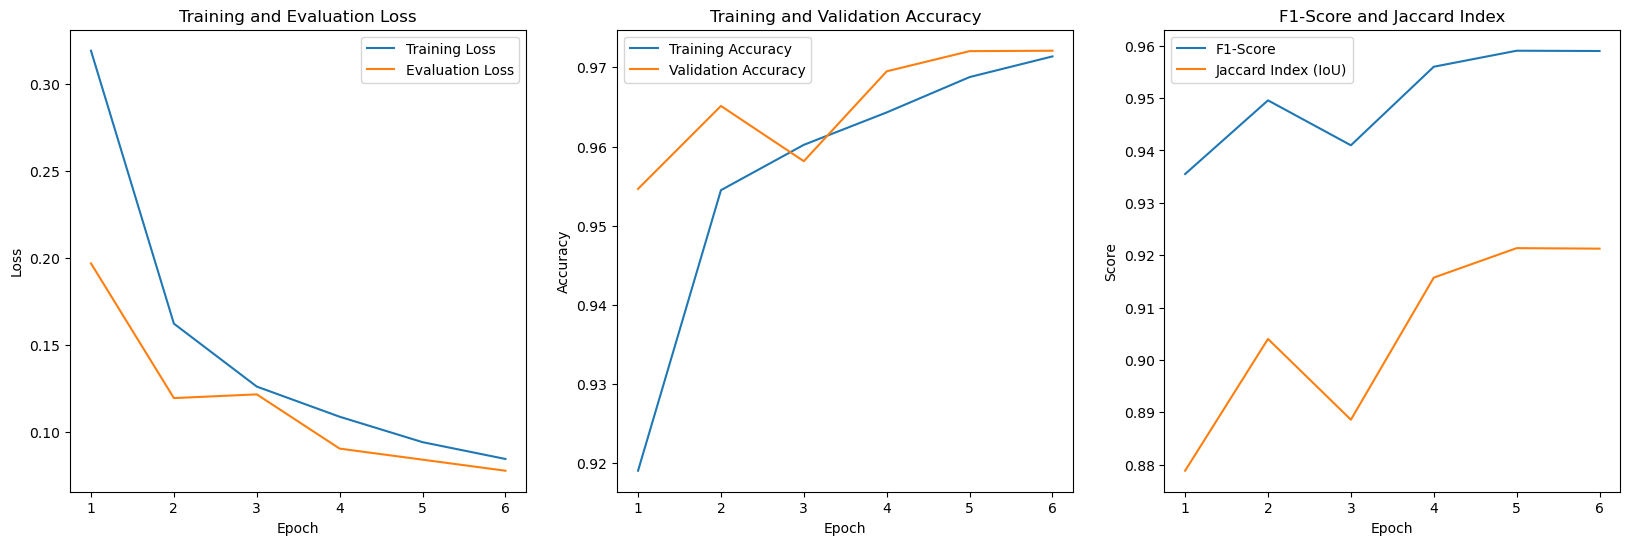

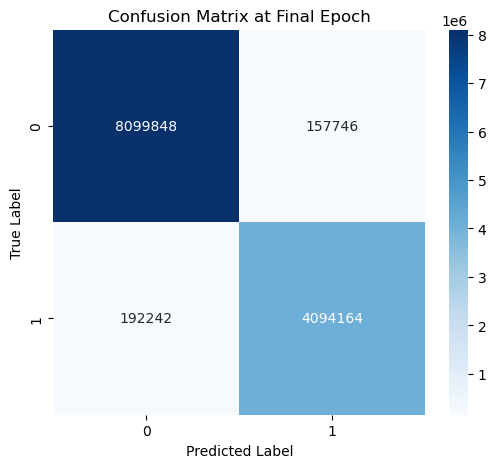

In [14]:
import torch.optim as optim
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, jaccard_score, confusion_matrix
import numpy as np
import seaborn as sns

def train_and_evaluate(model, train_loader, val_loader, criterion, optimizer, num_epochs=5):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    f1_scores = []
    jaccard_indices = []
    confusion_matrices = []

    for epoch in range(num_epochs):
        epoch_loss = 0
        total_correct_train = 0
        total_pixels_train = 0

        model.train()  # Set to training mode
        print(f"Start epoch {epoch+1}/{num_epochs}")

        for index, (image, mask) in enumerate(train_loader):
            image, mask = image.to(device), mask.to(device)

            optimizer.zero_grad()
            output = model(image)
            loss = criterion(output, mask)

            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            preds = torch.sigmoid(output) > 0.5
            total_correct_train += (preds == mask.byte()).sum().item()
            total_pixels_train += mask.numel()

        # Store training loss and accuracy
        train_losses.append(epoch_loss / len(train_loader))
        train_accuracy = total_correct_train / total_pixels_train
        train_accuracies.append(train_accuracy)

        print(f"Epoch [{epoch + 1}/{num_epochs}], Training Loss: {epoch_loss / len(train_loader):.4f}, Training Accuracy: {train_accuracy:.4f}")

        # Evaluation phase
        model.eval()  # Set to evaluation mode
        eval_loss = 0
        total_correct_eval = 0
        total_pixels_eval = 0
        all_preds = []
        all_masks = []
        
        with torch.no_grad():
            for eval_image, eval_mask in val_loader:
                eval_image, eval_mask = eval_image.to(device), eval_mask.to(device)
                
                eval_output = model(eval_image)
                eval_loss += criterion(eval_output, eval_mask).item()
        
                preds = torch.sigmoid(eval_output) > 0.5  # Thresholding to get binary predictions
                total_correct_eval += (preds == eval_mask.byte()).sum().item()
                total_pixels_eval += eval_mask.numel()
        
                # Convert predictions and masks to CPU for metric calculations
                all_preds.append(preds.cpu().numpy().flatten())
                all_masks.append(eval_mask.cpu().numpy().flatten())
        
        # Concatenate the arrays
        all_preds = np.concatenate(all_preds)
        all_masks = np.concatenate(all_masks)
        
        # Ensure all masks are binary before calculating metrics
        # If masks are continuous or have values other than 0 and 1, apply a threshold
        all_masks = (all_masks > 0.5).astype(int)  # Thresholding the masks to binary
        
        # Calculate F1-Score and Jaccard Index (IoU) using sklearn
        f1 = f1_score(all_masks, all_preds, average='binary')
        jaccard = jaccard_score(all_masks, all_preds, average='binary')
        f1_scores.append(f1)
        jaccard_indices.append(jaccard)
        
        print(f"F1-Score: {f1:.4f}, Jaccard Index (IoU): {jaccard:.4f}")


        # Confusion Matrix
        conf_matrix = confusion_matrix(all_masks, all_preds)
        confusion_matrices.append(conf_matrix)

        print(f"Confusion Matrix at Epoch {epoch + 1}:")
        print(conf_matrix)

        # Store evaluation loss and accuracy
        val_losses.append(eval_loss / len(val_loader))
        val_accuracy = total_correct_eval / total_pixels_eval
        val_accuracies.append(val_accuracy)

        print(f"Epoch [{epoch + 1}/{num_epochs}], Validation Loss: {eval_loss / len(val_loader):.4f}, Validation Accuracy: {val_accuracy:.4f}")

    # Plot the metrics at the end of all epochs
    plot_metrics(
        epochs=range(1, num_epochs + 1),
        train_losses=train_losses,
        eval_losses=val_losses,
        train_accuracies=train_accuracies,
        eval_accuracies=val_accuracies,
        f1_scores=f1_scores,
        jaccard_indices=jaccard_indices,
        confusion_matrices=confusion_matrices
    )

# Plot metrics function
def plot_metrics(epochs, train_losses, eval_losses, train_accuracies, eval_accuracies, f1_scores, jaccard_indices, confusion_matrices):
    plt.figure(figsize=(20, 6))

    # Plotting Losses
    plt.subplot(1, 3, 1)
    plt.plot(epochs, train_losses, label='Training Loss')
    plt.plot(epochs, eval_losses, label='Evaluation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Evaluation Loss')
    plt.legend()

    # Plotting Accuracy
    plt.subplot(1, 3, 2)
    plt.plot(epochs, train_accuracies, label='Training Accuracy')
    plt.plot(epochs, eval_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    # Plot F1-Score and Jaccard Index
    plt.subplot(1, 3, 3)
    plt.plot(epochs, f1_scores, label='F1-Score')
    plt.plot(epochs, jaccard_indices, label='Jaccard Index (IoU)')
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.title('F1-Score and Jaccard Index')
    plt.legend()
    plt.show()

    # Plot confusion matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(confusion_matrices[-1], annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix at Final Epoch')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

print("Running...")
train_and_evaluate(model, train_loader, val_loader, criterion, optimizer, num_epochs=6)


Testing the model on comma10k dataset...
Test Loss: 0.9183, Test Accuracy: 0.6891
F1-Score: 0.5169, Jaccard Index (IoU): 0.3485
Confusion Matrix:
[[40438267 20412584]
 [ 3092652 12574897]]


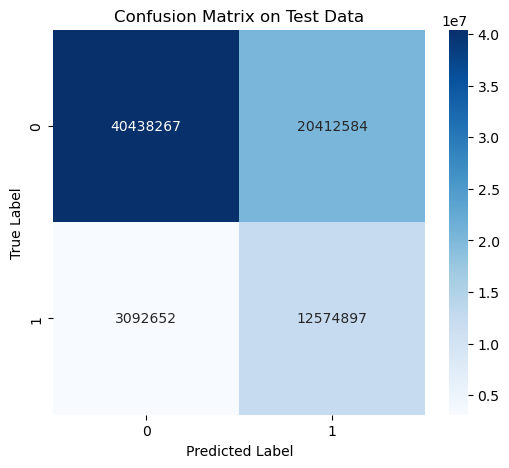

In [15]:
print("Testing the model on comma10k dataset...")
test_loss, test_accuracy, test_f1, test_jaccard, test_conf_matrix = test_model(model, comma10k_test_loader, criterion)

Testing the model on KITTI dataset...
Test Loss: 0.1752, Test Accuracy: 0.9375
F1-Score: 0.8257, Jaccard Index (IoU): 0.7031
Confusion Matrix:
[[11447355   487283]
 [  419299  2146927]]


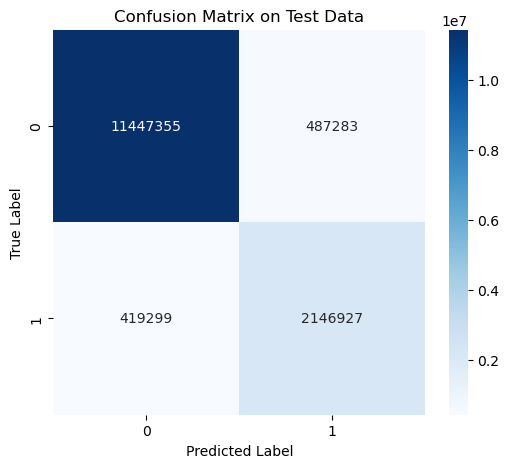

In [16]:
print("Testing the model on KITTI dataset...")
test_loss, test_accuracy, test_f1, test_jaccard, test_conf_matrix = test_model(model, kitti_loader, criterion)

Testing the model...
Test Loss: 0.1316, Test Accuracy: 0.9570
F1-Score: 0.9337, Jaccard Index (IoU): 0.8757
Confusion Matrix:
[[8200777  365931]
 [ 174056 3803236]]


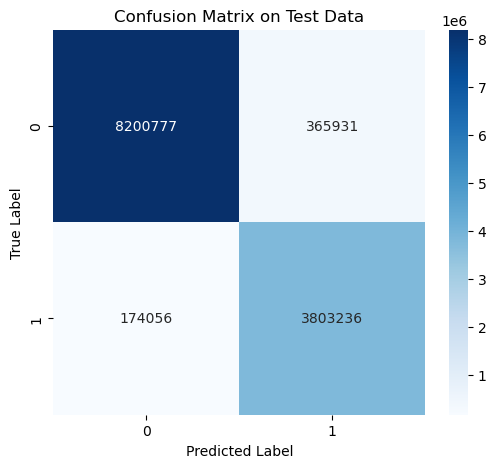

In [17]:
# Assuming you have already defined model, criterion, optimizer, and loaded the test_loader
print("Testing the model...")
test_loss, test_accuracy, test_f1, test_jaccard, test_confusion_matrix = test_model(model, cityscape_test_loader, criterion)
